# Gasoline Blending

The task is to determine the most profitable blend of gasoline products from given set of refinery streams.

![](https://www.researchgate.net/profile/Jeffrey-Kelly-2/publication/260356707/figure/fig4/AS:267835926642706@1440868469487/Typical-gasoline-blending-system-Color-figure-can-be-viewed-in-the-online-issue-which_W640.jpg)

<iframe width="560" height="315" src="https://www.youtube.com/embed/JCJ04-kKL0U?si=TF3-n35jjqrFzMkW" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

<iframe width="560" height="315" src="https://www.youtube.com/embed/GYRwWyG3Qqw?si=SWQ-P8DcTwskkRRy" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

In [1]:
# install Pyomo and solvers for Google Colab
import sys
on_colab = "google.colab" in sys.modules
if on_colab:
    !wget "https://raw.githubusercontent.com/IDAES/idaes-pse/main/scripts/colab_helper.py"
    import colab_helper
    colab_helper.install_idaes()
    colab_helper.install_ipopt()

# Set default font sizes for plots
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18
plt.rcParams['lines.linewidth'] = 3.0

In [2]:
import pandas as pd
import pyomo.environ as pyo

# Set default font sizes for plots
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18

## Gasoline Product Specifications

The gasoline products include regular and premium gasoline. In addition to the current price, the specifications include

* **octane** the minimum road octane number.  Road octane is the computed as the average of the Research Octane Number (RON) and Motor Octane Number (MON).
* **Reid Vapor Pressure** Upper and lower limits are specified for the Reid vapor pressure. The Reid vapor pressure is the absolute pressure exerted by the liquid at 100°F.
* **benzene** the maximum volume percentage of benzene allowed in the final product. Benzene helps to increase octane rating, but is also a treacherous environmental contaminant.


In [3]:
products = pd.DataFrame({
    'Regular'        : {'price': 2.75, 'octane': 87, 'RVPmin': 0.0, 'RVPmax': 15.0, 'benzene': 1.1},
    'Premium'        : {'price': 2.85, 'octane': 91, 'RVPmin': 0.0, 'RVPmax': 15.0, 'benzene': 1.1},
}).T

display(products)

,price,octane,RVPmin,RVPmax,benzene
Regular,2.75,87.0,0.0,15.0,1.1
Premium,2.85,91.0,0.0,15.0,1.1


## Stream Specifications

A typical refinery produces many intermediate streams that can be incorporated in a blended gasoline product. Here we provide data on seven streams that include:

* **Butane** n-butane is a C4 product stream produced from the light components of the crude being processed by the refinery. Butane is a highly volatile of gasoline.
* **LSR** Light straight run naptha is a 90°F to 190°F cut from the crude distillation column primarily consisting of straight chain C5-C6 hydrocarbons.
* **Isomerate** is the result of isomerizing LSR to produce branched molecules that results in higher octane number.
* **Reformate** is result of catalytic reforming heavy straight run napthenes to produce a high octane blending component, as well by-product hydrogen used elsewhere in the refinery for hydro-treating.
* **Reformate LB** is a is a low benzene variant of reformate.
* **FCC Naphta** is the product of a fluidized catalytic cracking unit designed to produce gasoline blending components from long chain hydrocarbons present in the crude oil being processed by the refinery.
* **Alkylate** The alkylation unit reacts iso-butane with low-molecular weight alkenes to produce a high octane blending component for gasoline.

The stream specifications include research octane and motor octane numbers for each blending component, the Reid vapor pressure, the benzene content, cost, and availability (in gallons per day). The road octane number is computed as the average of the RON and MON.

In [4]:
streams = pd.DataFrame({
    'Butane'       : {'RON': 93.0, 'MON': 92.0, 'RVP': 54.0, 'benzene': 0.00, 'cost': 0.85, 'avail': 30000},
    'LSR'          : {'RON': 78.0, 'MON': 76.0, 'RVP': 11.2, 'benzene': 0.73, 'cost': 2.05, 'avail': 35000},
    'Isomerate'    : {'RON': 83.0, 'MON': 81.1, 'RVP': 13.5, 'benzene': 0.00, 'cost': 2.20, 'avail': 0},
    'Reformate'    : {'RON':100.0, 'MON': 88.2, 'RVP':  3.2, 'benzene': 1.85, 'cost': 2.80, 'avail': 60000},
    'Reformate LB' : {'RON': 93.7, 'MON': 84.0, 'RVP':  2.8, 'benzene': 0.12, 'cost': 2.75, 'avail': 0},
    'FCC Naphtha'  : {'RON': 92.1, 'MON': 77.1, 'RVP':  1.4, 'benzene': 1.06, 'cost': 2.60, 'avail': 70000},
    'Alkylate'     : {'RON': 97.3, 'MON': 95.9, 'RVP':  4.6, 'benzene': 0.00, 'cost': 2.75, 'avail': 40000},
}).T

streams['octane'] = (streams['RON'] + streams['MON'])/2

display(streams)

,RON,MON,RVP,benzene,cost,avail,octane
Butane,93.0,92.0,54.0,0.00,0.85,30000.0,92.50
LSR,78.0,76.0,11.2,0.73,2.05,35000.0,77.00
Isomerate,83.0,81.1,13.5,0.00,2.20,0.0,82.05
Reformate,100.0,88.2,3.2,1.85,2.80,60000.0,94.10
Reformate LB,93.7,84.0,2.8,0.12,2.75,0.0,88.85
FCC Naphtha,92.1,77.1,1.4,1.06,2.60,70000.0,84.60
Alkylate,97.3,95.9,4.6,0.00,2.75,40000.0,96.60


## Questions We Want to Answer

1. What is the maximum profit possible using the current product specifications and available streams?

2. What are the marginal values of each blending stream? That is, how much would you be willing to pay for each additional gallon of the blending streams?

3. A marketing team says there is an opportunity to create a mid-grade gasoline product with a road octane number of 89 that would sell for $2.82/gallon, and with all other specifications the same. Would an additional profit be created? What at what price point does the mid-grade product enhance profits?

4. New environmental regulations have reduced the allowable benzene levels from 1.1 vol% to 0.62 vol%, and the maximum Reid vapor pressure from 15.0 to 9.0. What is the impact on profits?

## Blending Model

This simplified blending model assumes the product attributes can be computed as linear volume weighted averages of the component properties. Let the decision variable $x_{s,p} \geq 0$ be the volume, in gallons, of blending component $s \in S$ used in the final product $p \in P$.

### Objective

The objective is maximize profit, which is the difference between product revenue and stream costs. 

\begin{align}
\text{profit} & = \max_{x_{s,p}}\left( \sum_{p\in P} \text{Price}_p \sum_{s\in S} x_{s,p}
- \sum_{s\in S} \text{Cost}_s \sum_{p\in P} x_{s,p}\right) \\
& = \max_{x_{s,p}}\left(\sum_{p\in P}\sum_{s\in S}x_{s,p}(\text{Price}_p - \text{Cost}_s)\right)
\end{align}

### Raw Materials

The first constraints in any blending problem are normally the limits on available raw materials.

The blending constraint for octane can be written as 

\begin{align}
\frac{\sum_{s \in S} x_{s,p} \text{Octane}_s}{\sum_{s \in S} x_{s,p}} & \geq \text{Octane}_p & \forall p \in P
\end{align}

where $\text{Octane}_s$ refers to the octane rating of stream $s$, whereas $\text{Octane}_p$ refers to the octane rating of product $p$. Multiplying through by the denominator, and consolidating terms gives

\begin{align}
\sum_{s \in S} x_{s,p}\left(\text{Octane}_s - \text{Octane}_p\right) & \geq  0 & \forall p \in P
\end{align}

The same assumptions and development apply to the benzene constraint

\begin{align}
\sum_{s \in S} x_{s,p}\left(\text{Benzene}_s - \text{Benzene}_p\right) & \leq  0 & \forall p \in P
\end{align}

Reid vapor pressure, however, follows a somewhat different mixing rule.  For the Reid vapor pressure we have

\begin{align}
\sum_{s \in S} x_{s,p}\left(\text{RVP}_s^{1.25} - \text{RVP}_{min,p}^{1.25}\right) & \geq  0 & \forall p \in P \\
\sum_{s \in S} x_{s,p}\left(\text{RVP}_s^{1.25} - \text{RVP}_{max,p}^{1.25}\right) & \leq  0 & \forall p \in P
\end{align}

This model is implemented in the following cell.

## Pyomo Implementation

In [5]:
import pyomo.environ as pyo

from pyomo.environ import units as u

# Add USD as currency unit
# See https://pyomo.readthedocs.io/en/6.8.1/api/pyomo.core.base.units_container.PyomoUnitsContainer.html for details
u.load_definitions_from_strings(['USD = [currency]'])

milp_solver = 'cbc'

def gas_blending(products, streams):
    ''' Gasoline blending optimization problem

    Arguments:
        products: DataFrame with columns ['price', 'octane', 'RVPmin', 'RVPmax', 'benzene']
        streams: DataFrame with columns ['RON', 'MON', 'RVP', 'benzene', 'cost', 'avail']
        max_benzene: maximum benzene content in the final product (float)
        max_RVP: maximum Reid vapor pressure in the final product (float)
    
    Returns:
        m: Pyomo model (solved)

    '''

    m = pyo.ConcreteModel("Gasoline Blending")

    # Define sets
    m.STREAMS = pyo.Set(initialize=streams.index)
    m.PRODUCTS = pyo.Set(initialize=products.index)
    
    # Define units for variables and parameters
    m.x = pyo.Var(m.STREAMS, m.PRODUCTS, domain=pyo.NonNegativeReals, units=u.gallon)

    # Define parameters (data) for products
    m.price = pyo.Param(m.PRODUCTS, initialize=products['price'].to_dict(), units=u.USD/u.gallon)
    m.octane_p = pyo.Param(m.PRODUCTS, initialize=products['octane'].to_dict())
    m.RVPmin = pyo.Param(m.PRODUCTS, initialize=products['RVPmin'].to_dict())
    m.RVPmax = pyo.Param(m.PRODUCTS, initialize=products['RVPmax'].to_dict())
    m.benzene_p = pyo.Param(m.PRODUCTS, initialize=products['benzene'].to_dict())

    # Define parameters (data) for streams
    m.RON = pyo.Param(m.STREAMS, initialize=streams['RON'].to_dict())
    m.MON = pyo.Param(m.STREAMS, initialize=streams['MON'].to_dict())
    m.RVP_s = pyo.Param(m.STREAMS, initialize=streams['RVP'].to_dict())
    m.benzene_s = pyo.Param(m.STREAMS, initialize=streams['benzene'].to_dict())
    m.cost = pyo.Param(m.STREAMS, initialize=streams['cost'].to_dict(), units=u.USD/u.gallon)
    m.avail = pyo.Param(m.STREAMS, initialize=streams['avail'].to_dict(), units=u.gallon)
    m.octane_s = pyo.Param(m.STREAMS, initialize=streams['octane'].to_dict())

    # Define the objective function with units
    @m.Objective(sense=pyo.maximize)
    def profit(m):
        return sum(sum(m.x[s, p]*(m.price[p] - m.cost[s]) for s in m.STREAMS) for p in m.PRODUCTS)

    # Define constraints with units
    @m.Constraint(m.STREAMS)
    def raw_material_available(m, s):
        return sum(m.x[s, p] for p in m.PRODUCTS) <= m.avail[s]

    @m.Constraint(m.PRODUCTS)
    def octane(m, p):
        return sum(m.x[s, p]*(m.octane_s[s] - m.octane_p[p]) for s in m.STREAMS) >= 0

    @m.Constraint(m.PRODUCTS)
    def benzene(m, p):
        return sum(m.x[s, p]*(m.benzene_s[s] - m.benzene_p[p]) for s in m.STREAMS) <= 0

    @m.Constraint(m.PRODUCTS)
    def min_reid_vapor_pressure(m, p):
        return sum(m.x[s, p]*(m.RVP_s[s]**1.25 - m.RVPmin[p]**1.25) for s in m.STREAMS) >= 0

    @m.Constraint(m.PRODUCTS)
    def max_reid_vapor_pressure(m, p):
        return sum(m.x[s, p]*(m.RVP_s[s]**1.25 - m.RVPmax[p]**1.25) for s in m.STREAMS) <= 0

    solver = pyo.SolverFactory(milp_solver)
    solver.solve(m)
    
    return m

m = gas_blending(products, streams)

    


In [6]:
def get_key_results(m):
        # display results
        total_volume = sum(m.x[s,p]() for s in m.STREAMS for p in m.PRODUCTS) # gallons
        total_profit = m.profit() # dollars
        unit_profit = 100*total_profit/total_volume # cents per gallon
        print("Total Volume =", round(total_volume, 1), "gallons.")
        print("Total Profit =", round(total_profit, 1), "dollars.")
        print("Profit =", round(unit_profit,1), "cents per gallon.")

        return total_volume, total_profit, unit_profit

base_volume, base_profit, base_unit_profit = get_key_results(m)

soln = pd.DataFrame({s: {p: m.x[s,p]() for p in m.PRODUCTS} for s in m.STREAMS}).T
display(soln)

Total Volume = 235000.0 gallons.
Total Profit = 100425.0 dollars.
Profit = 42.7 cents per gallon.


,Regular,Premium
Butane,2.175457e+04,8245.428
LSR,9.211560e+03,25788.439
Isomerate,0.000000e+00,0.000
Reformate,1.978387e+04,40216.132
Reformate LB,0.000000e+00,0.000
FCC Naphtha,7.000000e+04,0.000
Alkylate,-7.275958e-12,40000.000


## Display Results (Baseline)

### Results for each Stream

In [7]:
def get_stream_results(m, streams):
    ''' Extract stream results from Pyomo model

    Argument:
        m: Pyomo model
        streams: DataFrame with columns ['RON', 'MON', 'RVP', 'benzene', 'cost', 'avail']

    Returns:
        stream_results: DataFrame with columns ['Total', 'Available', 'Unused (Slack)']
    
    '''

    # Create empty DataFrame
    stream_results = pd.DataFrame()

    # Loop over streams
    for s in m.STREAMS:

        # Loop over products
        for p in m.PRODUCTS:
            stream_results.loc[s,p] = round(m.x[s,p](), 1)
        
        # Calculate total volume, copy available volume
        stream_results.loc[s,'Total'] = round(sum(m.x[s,p]() for p in m.PRODUCTS), 1)
        stream_results.loc[s,'Available'] = streams.loc[s,'avail']
    
    # Calculate unused volume (slack)
    stream_results['Unused (Slack)'] = stream_results['Available'] - stream_results['Total']
    
    # Return DataFrame
    return stream_results

sr = get_stream_results(m, streams)
display(sr)

,Regular,Premium,Total,Available,Unused (Slack)
Butane,21754.6,8245.4,30000.0,30000.0,0.0
LSR,9211.6,25788.4,35000.0,35000.0,0.0
Isomerate,0.0,0.0,0.0,0.0,0.0
Reformate,19783.9,40216.1,60000.0,60000.0,0.0
Reformate LB,0.0,0.0,0.0,0.0,0.0
FCC Naphtha,70000.0,0.0,70000.0,70000.0,0.0
Alkylate,-0.0,40000.0,40000.0,40000.0,0.0


### Results for each Product

In [8]:
def get_product_results(m, streams, products):

    product_results = pd.DataFrame()
    for p in m.PRODUCTS:
        product_results.loc[p,'Volume'] = round(sum(m.x[s,p]() for s in m.STREAMS), 1)
        product_results.loc[p,'octane'] = round(sum(m.x[s,p]()*streams.loc[s,'octane'] for s in m.STREAMS)
                                                /product_results.loc[p,'Volume'], 1)
        product_results.loc[p,'RVP'] = round((sum(m.x[s,p]()*streams.loc[s,'RVP']**1.25 for s in m.STREAMS)
                                                /product_results.loc[p,'Volume'])**0.8, 1)
        product_results.loc[p,'benzene'] = round(sum(m.x[s,p]()*streams.loc[s,'benzene'] for s in m.STREAMS)
                                                /product_results.loc[p,'Volume'], 1)

    return product_results

pr = get_product_results(m, streams, products)
display(pr)

,Volume,octane,RVP,benzene
Regular,120750.0,87.0,15.0,1.0
Premium,114250.0,91.0,10.6,0.8


## Exercise 1: Marginal Value of Each Feedstock

What are the marginal blending rates of each stream?

Perturb the `avail` of each stream and record the results. We can then calculate the partial derivative of profit with respect to each perturbation.

In [9]:
import matplotlib.pyplot as plt

sensitivity = {}

for s in streams.index:
    epsilon = 1
    streams_perturb = streams.copy()
    streams_perturb.loc[s, 'avail'] += epsilon

    print("\n1 gallon increase in ",s," availability:")
    m_perturb = gas_blending(products, streams_perturb)
    p_volume, p_proft, p_unit_profit = get_key_results(m_perturb)
    sensitivity[s] = (p_proft - base_profit) / epsilon

sensitivity_series = pd.Series(sensitivity, name='sensitivity')


1 gallon increase in  Butane  availability:
Total Volume = 235001.0 gallons.
Total Profit = 100427.0 dollars.
Profit = 42.7 cents per gallon.

1 gallon increase in  LSR  availability:
Total Volume = 235001.0 gallons.
Total Profit = 100425.5 dollars.
Profit = 42.7 cents per gallon.

1 gallon increase in  Isomerate  availability:
Total Volume = 235001.0 gallons.
Total Profit = 100425.4 dollars.
Profit = 42.7 cents per gallon.

1 gallon increase in  Reformate  availability:
Total Volume = 235001.0 gallons.
Total Profit = 100425.1 dollars.
Profit = 42.7 cents per gallon.

1 gallon increase in  Reformate LB  availability:
Total Volume = 235001.0 gallons.
Total Profit = 100425.0 dollars.
Profit = 42.7 cents per gallon.

1 gallon increase in  FCC Naphtha  availability:
Total Volume = 235001.0 gallons.
Total Profit = 100425.1 dollars.
Profit = 42.7 cents per gallon.

1 gallon increase in  Alkylate  availability:
Total Volume = 235001.0 gallons.
Total Profit = 100425.2 dollars.
Profit = 42.7 c

These results are nice, but lets make a visualization we can present to management.

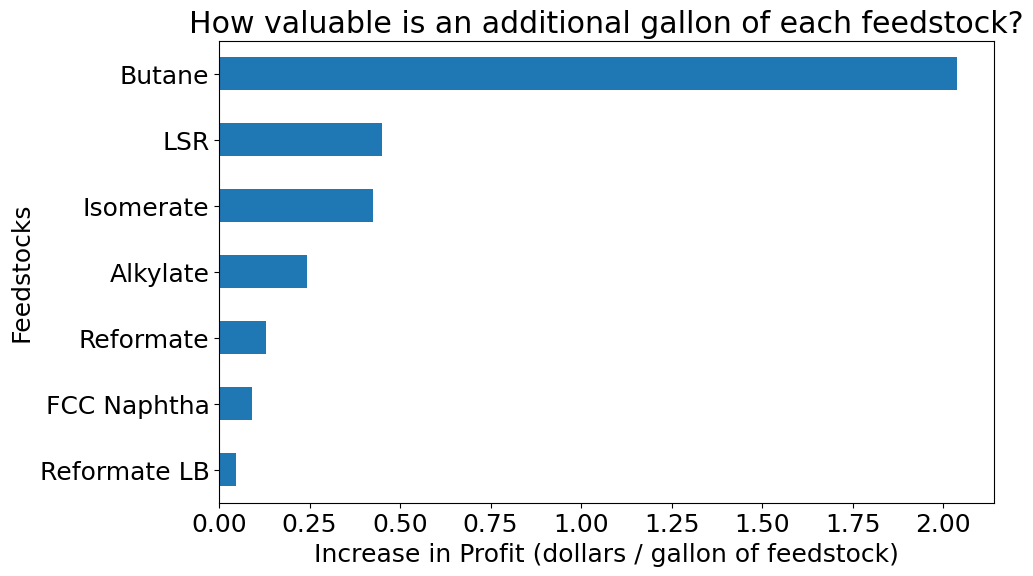

In [10]:
# Sort sensitivity for plotting
sensitivity_series = sensitivity_series.sort_values()

# Plot tornado diagram for sensitivity analysis
fig, ax = plt.subplots(figsize=(10, 6))
sensitivity_series.plot(kind='barh', ax=ax)
ax.set_title('How valuable is an additional gallon of each feedstock?')
ax.set_xlabel('Increase in Profit (dollars / gallon of feedstock)')
ax.set_ylabel('Feedstocks')
plt.show()

Which feed stream is most valuable and **why**? Someone with a business degree can make the plot above. You, with a chemical engineering degree, can answer the **why**.

## Exercise 2: New Product

The marketing team says there is an opportunity to create a mid-grade gasoline product with a road octane number of 89 that would sell for $2.82/gallon, and with all other specifications the same. Could an additional profit be created?

Create a new cell (or cells) below to compute a solution to this exercise.

In [11]:
products1 = pd.DataFrame({
    'Regular'        : {'price': 2.75, 'octane': 87, 'RVPmin': 0.0, 'RVPmax': 15.0, 'benzene': 1.1},
    'Midgrade'       : {'price': 2.82, 'octane': 89, 'RVPmin': 0.0, 'RVPmax': 15.0, 'benzene': 1.1},
    'Premium'        : {'price': 2.85, 'octane': 91, 'RVPmin': 0.0, 'RVPmax': 15.0, 'benzene': 1.1},
}).T

display(products1)

m1 = gas_blending(products1, streams)

sr1 = get_stream_results(m1, streams)
display(sr1)

pr1 = get_product_results(m1, streams, products1)
display(pr1)

,price,octane,RVPmin,RVPmax,benzene
Regular,2.75,87.0,0.0,15.0,1.1
Midgrade,2.82,89.0,0.0,15.0,1.1
Premium,2.85,91.0,0.0,15.0,1.1


,Regular,Midgrade,Premium,Total,Available,Unused (Slack)
Butane,849.5,29150.5,0.0,30000.0,30000.0,0.0
LSR,2646.2,32353.8,0.0,35000.0,35000.0,0.0
Isomerate,0.0,0.0,0.0,0.0,0.0,0.0
Reformate,2820.7,57179.3,0.0,60000.0,60000.0,0.0
Reformate LB,0.0,0.0,0.0,0.0,0.0,0.0
FCC Naphtha,0.0,70000.0,0.0,70000.0,70000.0,0.0
Alkylate,183.6,39816.4,0.0,40000.0,40000.0,0.0


/var/folders/b1/m1_w6rrd109bgym0_8fsxw_80000gp/T/ipykernel_25401/2558176032.py:6: RuntimeWarning: invalid value encountered in scalar divide
  product_results.loc[p,'octane'] = round(sum(m.x[s,p]()*streams.loc[s,'octane'] for s in m.STREAMS)
/var/folders/b1/m1_w6rrd109bgym0_8fsxw_80000gp/T/ipykernel_25401/2558176032.py:8: RuntimeWarning: invalid value encountered in scalar divide
  product_results.loc[p,'RVP'] = round((sum(m.x[s,p]()*streams.loc[s,'RVP']**1.25 for s in m.STREAMS)
/var/folders/b1/m1_w6rrd109bgym0_8fsxw_80000gp/T/ipykernel_25401/2558176032.py:10: RuntimeWarning: invalid value encountered in scalar divide
  product_results.loc[p,'benzene'] = round(sum(m.x[s,p]()*streams.loc[s,'benzene'] for s in m.STREAMS)


,Volume,octane,RVP,benzene
Regular,6500.0,87.0,15.0,1.1
Midgrade,228500.0,89.0,12.8,0.9
Premium,0.0,NaN,NaN,NaN


## Exercise 3: New Environmental Regulation

New environmental regulations have reduced the allowable benzene levels from 1.1 vol% to 0.62 vol%, and the maximum Reid vapor pressure from 15.0 to 9.0.

Compared to the base case (i.e., without the midgrade product), how does this change profitability? 

In [12]:
products2 = pd.DataFrame({
    'Regular'        : {'price': 2.75, 'octane': 87, 'RVPmin': 0.0, 'RVPmax': 9.0, 'benzene': 0.62},
    'Premium'        : {'price': 2.85, 'octane': 91, 'RVPmin': 0.0, 'RVPmax': 9.0, 'benzene': 0.62},
}).T

display(products2)

m2 = gas_blending(products2, streams)

sr2 = get_stream_results(m2, streams)
display(sr2)

pr2 = get_product_results(m2, streams, products2)
display(pr2)

,price,octane,RVPmin,RVPmax,benzene
Regular,2.75,87.0,0.0,9.0,0.62
Premium,2.85,91.0,0.0,9.0,0.62


,Regular,Premium,Total,Available,Unused (Slack)
Butane,8187.5,0.0,8187.5,30000.0,21812.5
LSR,28305.3,0.0,28305.3,35000.0,6694.7
Isomerate,0.0,0.0,0.0,0.0,0.0
Reformate,0.0,0.0,0.0,60000.0,60000.0
Reformate LB,0.0,0.0,0.0,0.0,0.0
FCC Naphtha,60824.3,0.0,60824.3,70000.0,9175.7
Alkylate,40000.0,0.0,40000.0,40000.0,0.0


/var/folders/b1/m1_w6rrd109bgym0_8fsxw_80000gp/T/ipykernel_25401/2558176032.py:6: RuntimeWarning: invalid value encountered in scalar divide
  product_results.loc[p,'octane'] = round(sum(m.x[s,p]()*streams.loc[s,'octane'] for s in m.STREAMS)
/var/folders/b1/m1_w6rrd109bgym0_8fsxw_80000gp/T/ipykernel_25401/2558176032.py:8: RuntimeWarning: invalid value encountered in scalar divide
  product_results.loc[p,'RVP'] = round((sum(m.x[s,p]()*streams.loc[s,'RVP']**1.25 for s in m.STREAMS)
/var/folders/b1/m1_w6rrd109bgym0_8fsxw_80000gp/T/ipykernel_25401/2558176032.py:10: RuntimeWarning: invalid value encountered in scalar divide
  product_results.loc[p,'benzene'] = round(sum(m.x[s,p]()*streams.loc[s,'benzene'] for s in m.STREAMS)


,Volume,octane,RVP,benzene
Regular,137317.1,87.0,9.0,0.6
Premium,0.0,NaN,NaN,NaN


## Exercise 4: Four Scenarios

Given the new product specifications in Exercise 3, let's consider using different refinery streams. In place of Reformate, the refinery could produce Reformate LB. (That is, one or the other of the two streams could be 60000 gallons per day, but not both).  Same for LSR and Isomerate. 

How should the refinery be operated to maximize profitability? Why is this the best solution? What intuition can you develop from the results?

### Scenario A: Reformate and LSR (base)

In [13]:
from dataclasses import dataclass

@dataclass
class SensitivityAnalysisResults:
    scenario_name: str
    reformate_LB: bool
    isomerate: bool
    total_volume: float
    total_profit: float
    unit_profit: float
    stream_input_data: pd.DataFrame
    stream_results: pd.DataFrame
    products: pd.DataFrame


def exercise4(scenario_name, reformate_LB, isomerate):
    ''' Sensitivity analysis for gasoline blending problem replacement feedstocks

    Arguments:
        reformate_LB: replace Reformate with Reformate LB stream (boolean)
        isomerate: replace LSR with Isomerate stream (boolean)

    Returns:
        results: SensitivityAnalysisResults object
    '''

    if reformate_LB:
        reformate = 0
        reformate_LB = 60000
    else:
        reformate = 60000
        reformate_LB = 0

    if isomerate:
        LSR = 0
        isomerate = 35000
    else:
        LSR = 35000
        isomerate = 0

    streams3 = pd.DataFrame({
        'Butane'       : {'RON': 93.0, 'MON': 92.0, 'RVP': 54.0, 'benzene': 0.00, 'cost': 0.85, 'avail': 30000},
        'LSR'          : {'RON': 78.0, 'MON': 76.0, 'RVP': 11.2, 'benzene': 0.73, 'cost': 2.05, 'avail': LSR},
        'Isomerate'    : {'RON': 83.0, 'MON': 81.1, 'RVP': 13.5, 'benzene': 0.00, 'cost': 2.20, 'avail': isomerate},
        'Reformate'    : {'RON':100.0, 'MON': 88.2, 'RVP':  3.2, 'benzene': 1.85, 'cost': 2.80, 'avail': reformate},
        'Reformate LB' : {'RON': 93.7, 'MON': 84.0, 'RVP':  2.8, 'benzene': 0.12, 'cost': 2.75, 'avail': reformate_LB},
        'FCC Naphtha'  : {'RON': 92.1, 'MON': 77.1, 'RVP':  1.4, 'benzene': 1.06, 'cost': 2.60, 'avail': 70000},
        'Alkylate'     : {'RON': 97.3, 'MON': 95.9, 'RVP':  4.6, 'benzene': 0.00, 'cost': 2.75, 'avail': 40000},
    }).T

    streams3['octane'] = (streams3['RON'] + streams3['MON'])/2

    display(streams3)

    # Create and solve optimization problem
    m3 = gas_blending(products2, streams3)

    # Extract results (part 1)
    total_volume, total_profit, unit_profit = get_key_results(m3)

    # Extract results (part 2)
    sr3 = get_stream_results(m3, streams3)
    display(sr3)

    # Extract results (part 3)
    pr3 = get_product_results(m3, streams3, products2)
    display(pr3)



    return SensitivityAnalysisResults(scenario_name, reformate_LB, isomerate, total_volume, total_profit, unit_profit, streams3, sr3, pr3)

scenarionA = exercise4('A', reformate_LB=True, isomerate=True)

# Store results for scenario A
results = []
results.append(scenarionA)


,RON,MON,RVP,benzene,cost,avail,octane
Butane,93.0,92.0,54.0,0.00,0.85,30000.0,92.50
LSR,78.0,76.0,11.2,0.73,2.05,0.0,77.00
Isomerate,83.0,81.1,13.5,0.00,2.20,35000.0,82.05
Reformate,100.0,88.2,3.2,1.85,2.80,0.0,94.10
Reformate LB,93.7,84.0,2.8,0.12,2.75,60000.0,88.85
FCC Naphtha,92.1,77.1,1.4,1.06,2.60,70000.0,84.60
Alkylate,97.3,95.9,4.6,0.00,2.75,40000.0,96.60


Total Volume = 217971.0 gallons.
Total Profit = 60022.2 dollars.
Profit = 27.5 cents per gallon.


,Regular,Premium,Total,Available,Unused (Slack)
Butane,8480.9,4490.1,12971.0,30000.0,17029.0
LSR,0.0,0.0,0.0,0.0,0.0
Isomerate,35000.0,0.0,35000.0,35000.0,0.0
Reformate,0.0,0.0,0.0,0.0,0.0
Reformate LB,60000.0,0.0,60000.0,60000.0,0.0
FCC Naphtha,45273.6,24726.4,70000.0,70000.0,0.0
Alkylate,12943.9,27056.1,40000.0,40000.0,0.0


,Volume,octane,RVP,benzene
Regular,161698.4,87.0,9.0,0.3
Premium,56272.6,91.0,9.0,0.5


### Scenario B: Reformate LB and LSR

In [14]:
scenarioB = exercise4('B',reformate_LB=True, isomerate=False)
results.append(scenarioB)

,RON,MON,RVP,benzene,cost,avail,octane
Butane,93.0,92.0,54.0,0.00,0.85,30000.0,92.50
LSR,78.0,76.0,11.2,0.73,2.05,35000.0,77.00
Isomerate,83.0,81.1,13.5,0.00,2.20,0.0,82.05
Reformate,100.0,88.2,3.2,1.85,2.80,0.0,94.10
Reformate LB,93.7,84.0,2.8,0.12,2.75,60000.0,88.85
FCC Naphtha,92.1,77.1,1.4,1.06,2.60,70000.0,84.60
Alkylate,97.3,95.9,4.6,0.00,2.75,40000.0,96.60


Total Volume = 219412.8 gallons.
Total Profit = 63791.2 dollars.
Profit = 29.1 cents per gallon.


,Regular,Premium,Total,Available,Unused (Slack)
Butane,13290.3,1122.5,14412.8,30000.0,15587.2
LSR,35000.0,0.0,35000.0,35000.0,0.0
Isomerate,0.0,0.0,0.0,0.0,0.0
Reformate,0.0,0.0,0.0,0.0,0.0
Reformate LB,60000.0,0.0,60000.0,60000.0,0.0
FCC Naphtha,63818.6,6181.4,70000.0,70000.0,0.0
Alkylate,33236.2,6763.8,40000.0,40000.0,0.0


,Volume,octane,RVP,benzene
Regular,205345.2,87.0,9.0,0.5
Premium,14067.7,91.0,9.0,0.5


### Scenario C: Reformate and Isomerate

In [15]:
scenarioC = exercise4('C', reformate_LB=False, isomerate=True)
results.append(scenarioC)

,RON,MON,RVP,benzene,cost,avail,octane
Butane,93.0,92.0,54.0,0.00,0.85,30000.0,92.50
LSR,78.0,76.0,11.2,0.73,2.05,0.0,77.00
Isomerate,83.0,81.1,13.5,0.00,2.20,35000.0,82.05
Reformate,100.0,88.2,3.2,1.85,2.80,60000.0,94.10
Reformate LB,93.7,84.0,2.8,0.12,2.75,0.0,88.85
FCC Naphtha,92.1,77.1,1.4,1.06,2.60,70000.0,84.60
Alkylate,97.3,95.9,4.6,0.00,2.75,40000.0,96.60


Total Volume = 171265.3 gallons.
Total Profit = 51312.5 dollars.
Profit = 30.0 cents per gallon.


,Regular,Premium,Total,Available,Unused (Slack)
Butane,7447.5,1528.9,8976.4,30000.0,21023.6
LSR,0.0,0.0,0.0,0.0,0.0
Isomerate,18754.0,16246.0,35000.0,35000.0,0.0
Reformate,0.0,17288.9,17288.9,60000.0,42711.1
Reformate LB,0.0,0.0,0.0,0.0,0.0
FCC Naphtha,68754.2,1245.8,70000.0,70000.0,0.0
Alkylate,22591.8,17408.2,40000.0,40000.0,0.0


,Volume,octane,RVP,benzene
Regular,117547.4,87.0,9.0,0.6
Premium,53717.9,91.0,9.0,0.6


### Scenario D: Reformate LB and Isomerate

In [16]:
resultsD = exercise4('D',reformate_LB=True, isomerate=True)
results.append(resultsD)

,RON,MON,RVP,benzene,cost,avail,octane
Butane,93.0,92.0,54.0,0.00,0.85,30000.0,92.50
LSR,78.0,76.0,11.2,0.73,2.05,0.0,77.00
Isomerate,83.0,81.1,13.5,0.00,2.20,35000.0,82.05
Reformate,100.0,88.2,3.2,1.85,2.80,0.0,94.10
Reformate LB,93.7,84.0,2.8,0.12,2.75,60000.0,88.85
FCC Naphtha,92.1,77.1,1.4,1.06,2.60,70000.0,84.60
Alkylate,97.3,95.9,4.6,0.00,2.75,40000.0,96.60


Total Volume = 217971.0 gallons.
Total Profit = 60022.2 dollars.
Profit = 27.5 cents per gallon.


,Regular,Premium,Total,Available,Unused (Slack)
Butane,8480.9,4490.1,12971.0,30000.0,17029.0
LSR,0.0,0.0,0.0,0.0,0.0
Isomerate,35000.0,0.0,35000.0,35000.0,0.0
Reformate,0.0,0.0,0.0,0.0,0.0
Reformate LB,60000.0,0.0,60000.0,60000.0,0.0
FCC Naphtha,45273.6,24726.4,70000.0,70000.0,0.0
Alkylate,12943.9,27056.1,40000.0,40000.0,0.0


,Volume,octane,RVP,benzene
Regular,161698.4,87.0,9.0,0.3
Premium,56272.6,91.0,9.0,0.5


### Tabular and Graphical Visualization

The detailed results above contain a ton of information. We need to distill them down into some visualizations that are easier to share with management.

In [17]:
results[0].products

,Volume,octane,RVP,benzene
Regular,161698.4,87.0,9.0,0.3
Premium,56272.6,91.0,9.0,0.5


In [18]:
import pandas as pd

# Initialize an empty list to store the data for each scenario
data = []

# Iterate over the results to extract the required information
for result in results:
    total_volume = round(result.total_volume,1)
    total_profit = round(result.total_profit, 1)
    unit_profit = round(result.unit_profit,1)
    regular_volume = result.products.loc['Regular', 'Volume']
    premium_volume = result.products.loc['Premium', 'Volume']
    data.append([result.scenario_name, result.reformate_LB, result.isomerate, regular_volume, premium_volume, total_volume, total_profit, unit_profit])

# Create a DataFrame from the data
df_results = pd.DataFrame(data, columns=['Scenario', 'LB Reformate (gal)', 'Isomerate (gal)', 'Regular (gal)', 'Premium (gal)', 'Total Volume (gal)', 'Total Profit (USD)', 'Unit Profit (cents/gal)'])
# Set the index of the DataFrame to 'Scenario'
df_results.set_index('Scenario', inplace=True)
# Display the DataFrame
display(df_results)

,LB Reformate (gal),Isomerate (gal),Regular (gal),Premium (gal),Total Volume (gal),Total Profit (USD),Unit Profit (cents/gal)
Scenario,,,,,,,
A,60000,35000,161698.4,56272.6,217971.0,60022.2,27.5
B,60000,0,205345.2,14067.7,219412.8,63791.2,29.1
C,0,35000,117547.4,53717.9,171265.3,51312.5,30.0
D,60000,35000,161698.4,56272.6,217971.0,60022.2,27.5


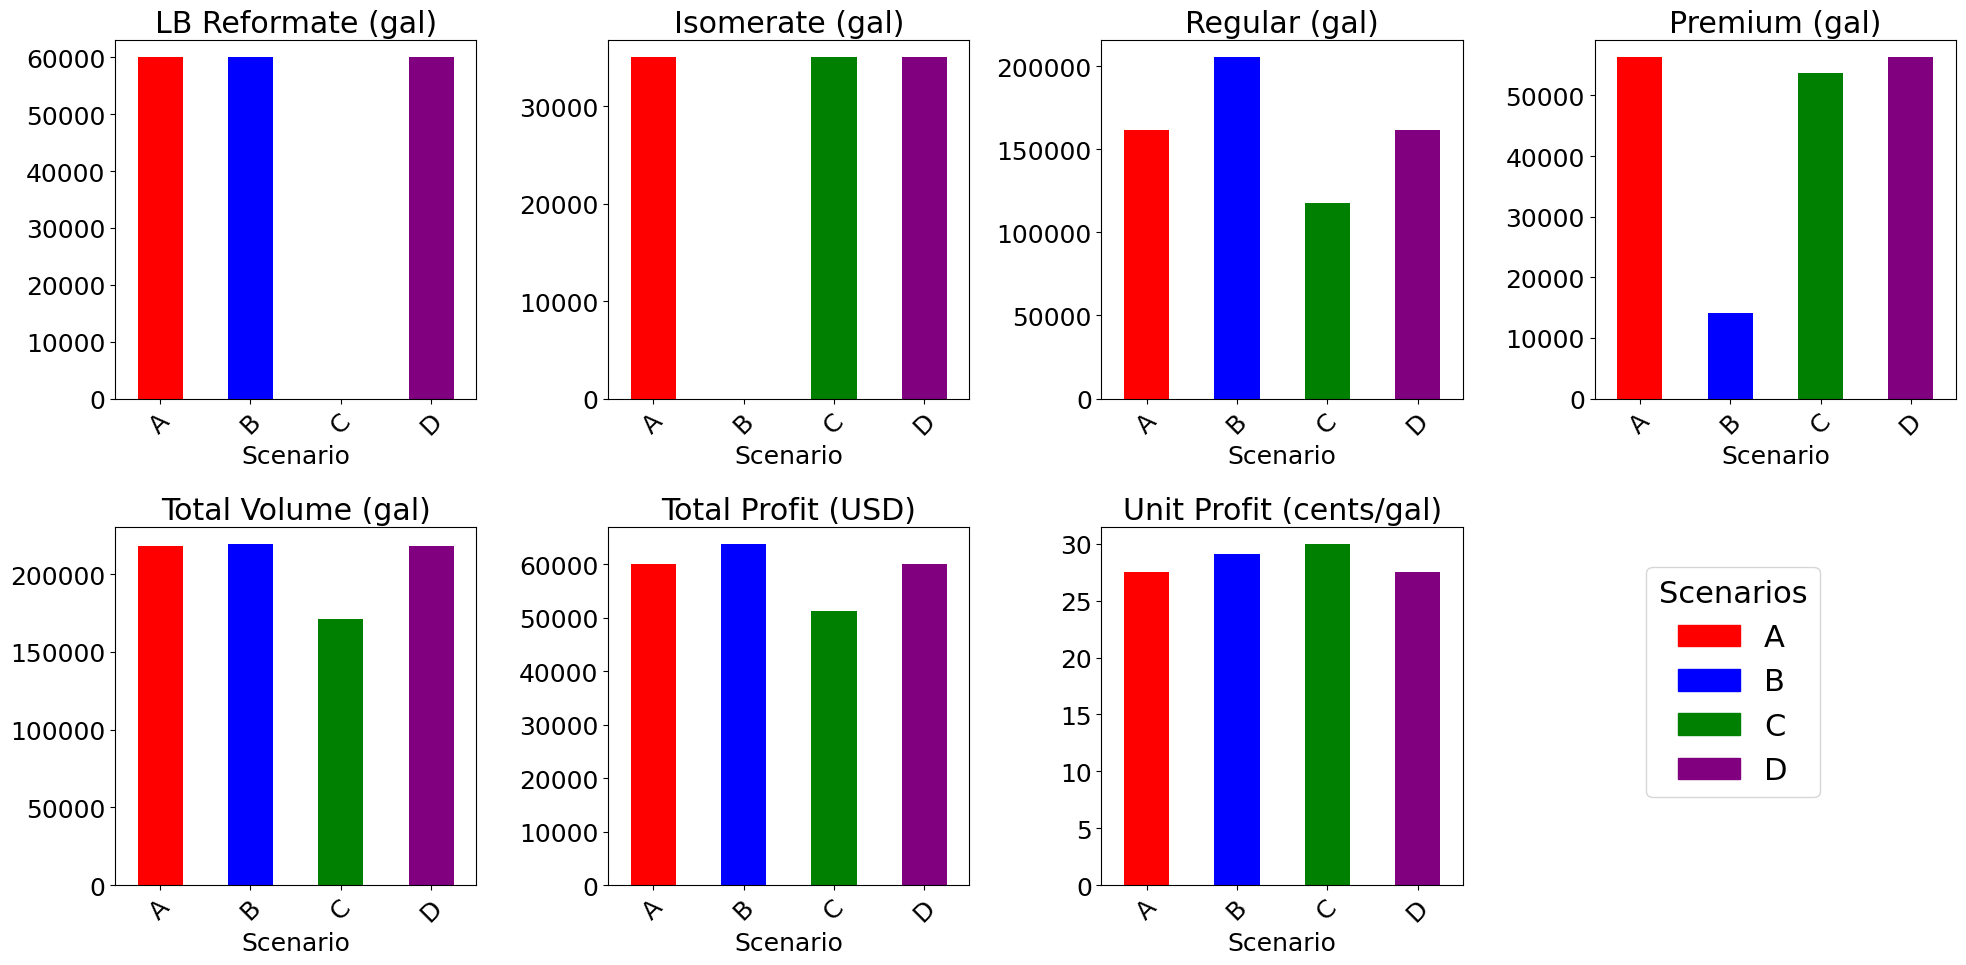

In [19]:
# Create a figure with 8 subplots (2 rows, 4 columns)
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# List of columns to plot
columns = df_results.columns

# Define colors for each scenario
colors = ['red', 'blue', 'green', 'purple']

# Plot each column in a separate subplot
for i, col in enumerate(columns):
    ax = axs[i // 4, i % 4]
    df_results[col].plot(kind='bar', ax=ax, color=colors)
    ax.set_title(col)
    ax.set_xticklabels(df_results.index, rotation=45)

# Remove the eighth subplot (bottom-right) and add the legend
fig.delaxes(axs[1, 3])
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
labels = ['A', 'B', 'C', 'D']
fig.legend(handles, labels, loc='center', title='Scenarios', title_fontsize=22, bbox_to_anchor=(0.875, 0.3), fontsize=22)

# Adjust layout
plt.tight_layout()
plt.show()

## Recommended Extensions

Use the analysis code developed in Exercise 4 to revisit the question in Exercise 1: why does butane have the most marginal value?

Teach yourself about KKT/Lagrange multipliers in optimization. Next, compare the multipliers from the base case to the sensitivities computed in Exercise 1. What is the interpretation of the multipliers?